# my website https://blog.csdn.net/Linli522362242/article/details/100735167

In [87]:
#https://blog.csdn.net/Static_at/article/details/81463072

#Under the Anaconda Prompt
#pip install fake-useragent
from fake_useragent import UserAgent
from selenium import webdriver
from lxml import etree
import pandas as pd
import re
import numpy as np

In [88]:
domainList=["http://free-proxy.cz"]
domain = domainList[0]
base="/zh/proxylist/main/1"
print(domain+base)

http://free-proxy.cz/zh/proxylist/main/1


# 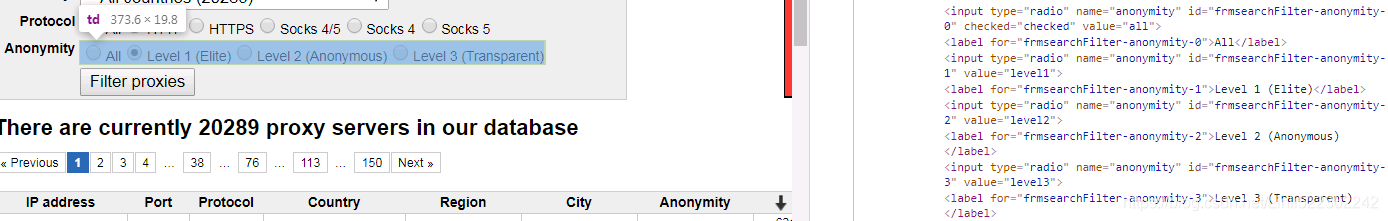

# responding to anti-crawler

In [89]:
userAgent=UserAgent()
#print(userAgent.random) 
#Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_2) AppleWebKit/537.17 (KHTML, like Gecko) Chrome/24.0.1309.0 Safari/537.17
#The actual userAgent
# (right click your mouse then select Inspection
# and then you can find it from Headers by clicking any elementName Under the Name in Network )
header = {'UserAgent':"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.100 Safari/537.36"}
#print(header['UserAgent'])
#Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.100 Safari/537.36

options = webdriver.ChromeOptions()
options.add_argument("'user-agent=" + header['UserAgent'] + "'")
options.add_argument('--diable-gpu') # google document mentioned this attribute can avoid some bugs
options.add_experimental_option('excludeSwitches',['enable-automation'])
#set the browser as developer model, prevent the website identifying that you are using Selenium
#browser = webdriver.Chrome(executable_path='D:/chromedriver/chromedriver',
#                           chrome_options=options)
#run command("window.navigator.webdriver")in the Console of the inspection
#result: undefine  # means: regular browser

In [112]:
class GetIp():
    def __init__(self, domain, baseUrl):
        self.domain = domain
        self.url=self.domain + str(baseUrl)
        self.browser = webdriver.Chrome(executable_path='D:/chromedriver/chromedriver',
                                        chrome_options=options
                                       )
        from selenium.webdriver.support.ui import WebDriverWait
        self.wait = WebDriverWait(self.browser, 20)
    def __del__(self):
        self.browser.close() #close current browser's window or tab
        #self.browser.quit() #close browser  #do not use here if you don't want lost the connection
    
    def get_webpagecontent(self):
        print(self.url)
        self.browser.get(self.url)
        from selenium.webdriver.support import expected_conditions as EC
        from selenium.webdriver.common.by import By
        self.wait.until(EC.presence_of_element_located((By.ID, "proxy_list")))
        pageSource = self.browser.page_source
        return pageSource
    
    def parse_webData(self,pageSource):
        df=pd.read_html(pageSource, header=0)[1]
        #print(df)
        #import re
        selector = etree.HTML(pageSource)
        countryDict={}
        countryNames=selector.xpath('//select/option/text()')
        countryAbbreviations=selector.xpath('//select/option/@value')
        for i in range(2,len(countryNames)):
            cname=re.findall('[\u4e00-\u9fa5_a-zA-Z]+',countryNames[i])[0] 
            countryDict[cname]=cname+countryAbbreviations[i]
        #print(countryDict['美国'])
        
        anonymousDict = {'高匿名': 'Highly','匿名':'anonymous','透明':'transparency'}
        for r in range(df.shape[0]):
            ipAddress = re.findall(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b',df.loc[r,'IP地址'])
            port=re.findall(r'[0-9]+\b',str(df.loc[0,'端口']))[0]
            if len(ipAddress)==0:
                #print(df.loc[r,'IP地址'])
                df.drop([r],inplace=True)
            else:
                df.loc[r,'IP地址']=ipAddress[0]
                df.loc[r,'端口']=port
                if df.loc[r, '匿名'] in anonymousDict.keys():
                    df.loc[r, '匿名'] = anonymousDict[df.loc[r, '匿名']]
                
                if df.loc[r,'国家'] in countryDict.keys():
                    df.loc[r,'国家'] = countryDict[df.loc[r,'国家']]
                
                #import numpy as np
                if pd.isnull(df.loc[r,'区域']) and pd.isnull(df.loc[r,'城市']):        
                    #df.loc[r,'区域']=np.nan#pd.NaT
                    #df.loc[r,'城市']=np.nan#pd.NaT
                    df.loc[r,'Location']=np.nan
                elif pd.isnull(df.loc[r,'区域']) and pd.isnull(df.loc[r,'城市'])==False:
                    df.loc[r,'Location']=df.loc[r,'城市']
                elif pd.isnull(df.loc[r,'区域'])==False and pd.isnull(df.loc[r,'城市']):
                    df.loc[r,'Location']=df.loc[r,'区域']
                else:
                    df.loc[r,'Location']=df.loc[r,'区域']+", "+df.loc[r,'城市']
            
        df.drop(['区域','城市'],axis=1,inplace=True)
        
        df.columns = [ 'IP Address', 'Port', 'Protocol','Country', 'Anonymous',
                       'Speed','Available', 'Response Time', 'Update','Location']
        #df.set_index('IP Address',inplace=True)
        
        return df
    
    def crawler(self):#get first 5 pages' data
        pageSource=self.get_webpagecontent()
        ipDataFrame = self.parse_webData(pageSource)
        #print(ipDataFrame)
        
        hasNextPage = True
        pageNumber=0
        while hasNextPage and pageNumber < 3:
            hasNextPage=False
            #from lxml import etree
            selector = etree.HTML(pageSource)
            try:
                #nextPageUrl = selector.xpath('//div[@class="pagination"]/a[contains(text(),"其他 »")]/@href')[0]
                nextPageUrl = selector.xpath('//div[@class="paginator"]/a[last()]/@href')[0]
                if nextPageUrl:
                    hasNextPage = True
                else:
                    hasNextPage = False
            except:
                break
            self.url=self.domain + nextPageUrl
            pageSource = self.get_webpagecontent()
            currentIpDataFrame = self.parse_webData(pageSource)
            pageNumber=pageNumber+1
            ipDataFrame=pd.concat([ipDataFrame,currentIpDataFrame])
        return ipDataFrame
    
    def execute2(self):#get at most (first) 5 pages's data for each value on selection('country')
        pageSource=self.get_webpagecontent()
        self.browser.implicitly_wait(10)
        
        selector = etree.HTML(pageSource)
        #get all values belonging to select tag
        countryAbbreviations=selector.xpath('//select/option/@value')
        #print(countryAbbreviations)
        
        from selenium.webdriver.support.select import Select    
        #from selenium.webdriver.common.action_chains import ActionChains #import mouse action event package
        from time import sleep
        
        selectionBox = self.browser.find_element_by_id('frmsearchFilter-country')
        
        #Select(selectionBox).select_by_value("BT")
        #Select(selectionBox).select_by_value("MO")
        #ipCrawler.browser.find_element_by_name("send").click()
        
        counterCountry=0
        ipDataFrame=None # create a empty dataframe
        for value in countryAbbreviations:     
            if value != 'all' and counterCountry<5:
                Select(selectionBox).select_by_value(value)
                ipCrawler.browser.find_element_by_name("send").click()
                
                ipCrawler.url=self.browser.current_url #reset url since each page's url is different
                if ipDataFrame is None:
                    ipDataFrame=ipCrawler.crawler()
                else:
                    ipDataFrame=ipDataFrame.append(ipCrawler.crawler(),ignore_index=True)
                sleep(2)
                counterCountry=counterCountry+1
                        
                #since each page's select tag is a instance
                selectionBox = ipCrawler.browser.find_element_by_id('frmsearchFilter-country')
        self.browser.quit()#close browser
        return ipDataFrame


# level1:High  #level2:Anonymous #level3:Transparent

In [117]:
ipCrawler=GetIp(domain,base)
#ipDataFrame=ipCrawler.crawler()

ipDataFrame=ipCrawler.execute2()
ipDataFrame

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: use options instead of chrome_options
  


http://free-proxy.cz/zh/proxylist/main/1
http://free-proxy.cz/zh/proxylist/country/AP/all/ping/all
http://free-proxy.cz/zh/proxylist/country/MO/all/ping/all
http://free-proxy.cz/zh/proxylist/country/BT/all/ping/all
http://free-proxy.cz/zh/proxylist/country/TL/all/ping/all
http://free-proxy.cz/zh/proxylist/country/CN/all/ping/all
http://free-proxy.cz/zh/proxylist/country/CN/all/ping/all/2
http://free-proxy.cz/zh/proxylist/country/CN/all/ping/all/3
http://free-proxy.cz/zh/proxylist/country/CN/all/ping/all/4


,IP Address,Port,Protocol,Country,Anonymous,Speed,Available,Response Time,Update,Location
0,35.194.190.11,80,HTTPS,Asia/Pacific Region,Highly,141 kB/s,95%,1876 ms,4 小时 前,NaN
1,35.198.192.157,80,HTTP,Asia/Pacific Region,Highly,116 kB/s,69.7%,6152 ms,4 小时 前,NaN
2,60.246.173.103,8118,HTTP,MacauMO,Highly,NaN,100%,2413 ms,6 小时 前,"Ilhas, Macau"
3,202.175.123.148,8118,HTTP,MacauMO,Highly,NaN,23.2%,12829 ms,7 小时 前,"Ilhas, Macau"
4,220.158.236.40,3128,HTTPS,不丹BT,transparency,26 kB/s,90.6%,31881 ms,10 小时 前,NaN
5,103.26.95.142,4444,SOCKS4,东帝汶TL,Highly,NaN,85%,1494 ms,6 小时 前,Same
6,103.30.115.162,4444,HTTP,东帝汶TL,transparency,146 kB/s,75.1%,3272 ms,6 小时 前,"Dili, Dili"
7,180.189.168.66,4444,HTTPS,东帝汶TL,transparency,NaN,34.2%,6437 ms,8 小时 前,NaN
8,139.159.47.22,39593,SOCKS4,中国CN,Highly,608 kB/s,92.2%,248 ms,2 小时 前,"Beijing, Beijing"
9,139.159.48.155,39593,SOCKS4,中国CN,Highly,565 kB/s,96.5%,355 ms,4 小时 前,"Beijing, Beijing"


In [29]:
if __name__=="__main__":
    ipCrawler=GetIp(domain,base)
    pageSource=ipCrawler.get_webpagecontent()
    ipCrawler.browser.implicitly_wait(10)
        
    selector = etree.HTML(pageSource)
    #get all values belonging to select tag
    countryAbbreviations=selector.xpath('//select/option/@value')
    #print(countryAbbreviations)
        
    #https://seleniumhq.github.io/selenium/docs/api/py/_modules/selenium/webdriver/support/select.html
    from selenium.webdriver.support.select import Select    
    #from selenium.webdriver.common.action_chains import ActionChains #import mouse action event package
    from time import sleep
        
    selectionBox = ipCrawler.browser.find_element_by_id('frmsearchFilter-country')
        
    #test the specified option
    #Select(selectionBox).select_by_value("BT")
    #Select(selectionBox).select_by_value("MO")
        
    counterCountry=0
    for value in countryAbbreviations:
        
        if value != 'all' and counterCountry<5:
            Select(selectionBox).select_by_value("BT")
            Select(selectionBox).select_by_value(value)
            ipCrawler.browser.find_element_by_name("send").click()
            sleep(2)
            counterCountry=counterCountry+1
            print("++++")
            #ipCrawler.url=self.browser.current_url
            #ipDataFrame=ipCrawler.crawler() #crawler
                
            #since each page's select tag is a instance
            selectionBox = ipCrawler.browser.find_element_by_id('frmsearchFilter-country')
        else:
             break
#ipCrawler=GetIp(domain,base)
#ipDataFrame=ipCrawler.crawler()

#ipDataFrame=ipCrawler.execute2()
#ipDataFrame

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: use options instead of chrome_options
  


http://free-proxy.cz/zh/proxylist/main/1


In [26]:
ipDataFrame.set_index('IP Address',inplace=True)
ipDataFrame

,Port,Protocol,Country,Anonymous,Speed,Available,Response Time,Update,Location
IP Address,,,,,,,,,
60.246.173.103,8118,HTTP,MacauMO,Highly,NaN,100%,4176 ms,12 小时 前,"Ilhas, Macau"
60.246.89.102,8118,HTTP,MacauMO,Highly,NaN,81.3%,11122 ms,8 小时 前,"Ilhas, Taipa"
202.175.123.148,8118,HTTP,MacauMO,Highly,17 kB/s,23.2%,14578 ms,11 小时 前,"Ilhas, Macau"


In [283]:
selector = etree.HTML(pageSource)
nextPageUrl = selector.xpath('//div[@class="paginator"]/a[last()]/@href')[0]
nextPageUrl

'/zh/proxylist/main/2'

In [284]:
countryNames=selector.xpath('//select/option/text()')
countryNames

['+ 所有国家 (20705)',
 'Asia/Pacific Region (1)',
 'Macau (4)',
 '不丹 (1)',
 '东帝汶 (2)',
 '中国 (1006)',
 '丹麦 (6)',
 '乌克兰 (526)',
 '乌兹别克斯坦 (1)',
 '乌干达 (15)',
 '乌拉圭 (9)',
 '乍得 (1)',
 '也门 (7)',
 '亚美尼亚 (67)',
 '以色列 (6)',
 '伊拉克 (102)',
 '伊朗 (475)',
 '佛得角 (1)',
 '俄国 (1539)',
 '保加利亚 (166)',
 '克罗地亚 (20)',
 '关岛 (1)',
 '几内亚 (11)',
 '利比亚 (29)',
 '利比里亚 (2)',
 '加拿大 (97)',
 '加纳 (7)',
 '加蓬 (2)',
 '匈牙利 (92)',
 '南苏丹 (1)',
 '南非 (268)',
 '博茨瓦纳 (12)',
 '卢旺达 (3)',
 '卢森堡 (6)',
 '印尼 (2341)',
 '印度 (1794)',
 '危地马拉 (19)',
 '厄瓜多尔 (328)',
 '叙利亚 (17)',
 '台湾 (91)',
 '吉尔吉斯斯坦 (20)',
 '吉布提 (1)',
 '哈萨克斯坦 (45)',
 '哥伦比亚 (374)',
 '哥斯达黎加 (17)',
 '喀麦隆 (16)',
 '土耳其 (262)',
 '圣马丁（荷兰部分） (1)',
 '圭亚那 (1)',
 '坦桑尼亚 (29)',
 '埃及 (20)',
 '埃塞俄比亚 (1)',
 '塔吉克斯坦 (1)',
 '塞尔维亚 (149)',
 '塞拉利昂 (2)',
 '塞浦路斯 (11)',
 '塞舌尔 (44)',
 '墨西哥 (228)',
 '多明尼加共和国 (12)',
 '奥地利 (26)',
 '委内瑞拉 (37)',
 '孟加拉国 (890)',
 '安哥拉 (5)',
 '安道尔 (2)',
 '尼加拉瓜 (7)',
 '尼日利亚 (69)',
 '尼泊尔 (129)',
 '巴勒斯坦领土 (35)',
 '巴基斯坦 (157)',
 '巴布亚新几内亚 (2)',
 '巴拉圭 (31)',
 '巴拿马 (19)',
 '巴西 (2891)',


In [285]:
countryName[2]

'Macau (4)'

In [286]:
#https://blog.csdn.net/bmjhappy/article/details/80512917
re.findall('[\u4e00-\u9fa5_a-zA-Z]+',countryName[2]) 

['Macau']

In [287]:
countryAbbreviations=selector.xpath('//select/option/@value')
countryAbbreviations

['all',
 'AP',
 'MO',
 'BT',
 'TL',
 'CN',
 'DK',
 'UA',
 'UZ',
 'UG',
 'UY',
 'TD',
 'YE',
 'AM',
 'IL',
 'IQ',
 'IR',
 'CV',
 'RU',
 'BG',
 'HR',
 'GU',
 'GN',
 'LY',
 'LR',
 'CA',
 'GH',
 'GA',
 'HU',
 'SS',
 'ZA',
 'BW',
 'RW',
 'LU',
 'ID',
 'IN',
 'GT',
 'EC',
 'SY',
 'TW',
 'KG',
 'DJ',
 'KZ',
 'CO',
 'CR',
 'CM',
 'TR',
 'SX',
 'GY',
 'TZ',
 'EG',
 'ET',
 'TJ',
 'RS',
 'SL',
 'CY',
 'SC',
 'MX',
 'DO',
 'AT',
 'VE',
 'BD',
 'AO',
 'AD',
 'NI',
 'NG',
 'NP',
 'PS',
 'PK',
 'PG',
 'PY',
 'PA',
 'BR',
 'BF',
 'BI',
 'GR',
 'DE',
 'IT',
 'QA',
 'LV',
 'NO',
 'CZ',
 'MD',
 'MA',
 'SZ',
 'SK',
 'SI',
 'SG',
 'NZ',
 'JP',
 'CL',
 'KH',
 'GE',
 'EU',
 'BE',
 'MU',
 'SA',
 'FR',
 'PL',
 'PR',
 'BA',
 'TH',
 'ZW',
 'HN',
 'AU',
 'IE',
 'EE',
 'JM',
 'TT',
 'BO',
 'SE',
 'CH',
 'BY',
 'KW',
 'PE',
 'TN',
 'LT',
 'SO',
 'JO',
 'NA',
 'MM',
 'RO',
 'US',
 'VI',
 'LA',
 'GB',
 'KE',
 'FI',
 'SD',
 'NL',
 'MZ',
 'LS',
 'PH',
 'SV',
 'WS',
 'PT',
 'MN',
 'ES',
 'BJ',
 'ZM',
 'GQ',
 'VN',
 'CD'

In [291]:
countryDict={}
for i in range(2,len(countryNames)):
    cname=re.findall('[\u4e00-\u9fa5_a-zA-Z]+',countryNames[i])[0] 
    countryDict[cname]=countryAbbreviations[i]
countryDict

{'Macau': 'MO',
 '不丹': 'BT',
 '东帝汶': 'TL',
 '中国': 'CN',
 '丹麦': 'DK',
 '乌克兰': 'UA',
 '乌兹别克斯坦': 'UZ',
 '乌干达': 'UG',
 '乌拉圭': 'UY',
 '乍得': 'TD',
 '也门': 'YE',
 '亚美尼亚': 'AM',
 '以色列': 'IL',
 '伊拉克': 'IQ',
 '伊朗': 'IR',
 '佛得角': 'CV',
 '俄国': 'RU',
 '保加利亚': 'BG',
 '克罗地亚': 'HR',
 '关岛': 'GU',
 '几内亚': 'GN',
 '利比亚': 'LY',
 '利比里亚': 'LR',
 '加拿大': 'CA',
 '加纳': 'GH',
 '加蓬': 'GA',
 '匈牙利': 'HU',
 '南苏丹': 'SS',
 '南非': 'ZA',
 '博茨瓦纳': 'BW',
 '卢旺达': 'RW',
 '卢森堡': 'LU',
 '印尼': 'ID',
 '印度': 'IN',
 '危地马拉': 'GT',
 '厄瓜多尔': 'EC',
 '叙利亚': 'SY',
 '台湾': 'TW',
 '吉尔吉斯斯坦': 'KG',
 '吉布提': 'DJ',
 '哈萨克斯坦': 'KZ',
 '哥伦比亚': 'CO',
 '哥斯达黎加': 'CR',
 '喀麦隆': 'CM',
 '土耳其': 'TR',
 '圣马丁': 'SX',
 '圭亚那': 'GY',
 '坦桑尼亚': 'TZ',
 '埃及': 'EG',
 '埃塞俄比亚': 'ET',
 '塔吉克斯坦': 'TJ',
 '塞尔维亚': 'RS',
 '塞拉利昂': 'SL',
 '塞浦路斯': 'CY',
 '塞舌尔': 'SC',
 '墨西哥': 'MX',
 '多明尼加共和国': 'DO',
 '奥地利': 'AT',
 '委内瑞拉': 'VE',
 '孟加拉国': 'BD',
 '安哥拉': 'AO',
 '安道尔': 'AD',
 '尼加拉瓜': 'NI',
 '尼日利亚': 'NG',
 '尼泊尔': 'NP',
 '巴勒斯坦领土': 'PS',
 '巴基斯坦': 'PK',
 '巴布亚新几内亚': 'PG',
 '巴拉圭': 'PY',
 '巴拿马

In [194]:
ipDataFrame

,IP Address,Port,Protocol,Country,Anonymous,Speed,Available,Response Time,Update,Location
0,174.138.41.153,3128,HTTP,美国,anonymous,6326 kB/s,100%,46 ms,7 小时 前,New Jersey North Bergen
1,159.89.95.202,3128,HTTP,美国,anonymous,6228 kB/s,NaN,50 ms,7 小时 前,New Jersey North Bergen
2,67.207.94.118,3128,HTTP,美国,Highly,6207 kB/s,81.9%,127 ms,7 小时 前,New Jersey North Bergen
3,178.128.151.27,3128,HTTP,希腊,Highly,6147 kB/s,82.4%,47 ms,7 小时 前,NaN
5,134.209.73.144,3128,HTTPS,美国,transparency,6136 kB/s,NaN,37 ms,3 小时 前,Massachusetts Mansfield
6,167.71.167.227,3128,HTTP,美国,anonymous,6114 kB/s,97.7%,39 ms,2 小时 前,New York New York
7,167.71.101.134,3128,HTTP,美国,anonymous,6084 kB/s,96.4%,47 ms,2 小时 前,New York New York
8,159.203.87.130,3128,HTTPS,美国,transparency,6076 kB/s,52.1%,121 ms,6 小时 前,New Jersey Clifton
9,68.183.147.115,3128,HTTP,美国,anonymous,6069 kB/s,100%,39 ms,3 小时 前,California Huntington Park
10,159.65.168.195,3128,HTTP,美国,Highly,6067 kB/s,71.5%,50 ms,3 小时 前,New Jersey Clifton


In [170]:
re.findall(r'[0-9]+\b',str(df.loc[0,'Port']))[0]

'3128'

In [128]:
df = ipCrawler.parse_webData(pageSource)
df

,IP地址,端口,协议,国家,区域,城市,匿名,速度,可用性,回复,最后更新
0,"document.write(Base64.decode(""MTc0LjEzOC40MS4x...",3128.0,HTTP,美国,New Jersey,North Bergen,匿名,6326 kB/s,100%,46 ms,6 小时 前
1,"document.write(Base64.decode(""MTU5Ljg5Ljk1LjIw...",3128.0,HTTP,美国,New Jersey,North Bergen,匿名,6228 kB/s,NaN,50 ms,6 小时 前
2,"document.write(Base64.decode(""NjcuMjA3Ljk0LjEx...",80.0,HTTP,美国,New Jersey,North Bergen,高匿名,6207 kB/s,81.9%,127 ms,6 小时 前
3,"document.write(Base64.decode(""MTc4LjEyOC4xNTEu...",80.0,HTTP,希腊,NaN,NaN,高匿名,6147 kB/s,82.4%,47 ms,5 小时 前
4,(adsbygoogle = window.adsbygoogle || []).push(...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"document.write(Base64.decode(""MTM0LjIwOS43My4x...",3128.0,HTTPS,美国,Massachusetts,Mansfield,透明,6136 kB/s,NaN,37 ms,2 小时 前
6,"document.write(Base64.decode(""MTY3LjcxLjE2Ny4y...",8080.0,HTTP,美国,New York,New York,匿名,6114 kB/s,97.7%,39 ms,30 分钟 前
7,"document.write(Base64.decode(""MTY3LjcxLjEwMS4x...",8080.0,HTTP,美国,New York,New York,匿名,6084 kB/s,96.4%,47 ms,41 分钟 前
8,"document.write(Base64.decode(""MTU5LjIwMy44Ny4x...",3128.0,HTTPS,美国,New Jersey,Clifton,透明,6076 kB/s,52.1%,121 ms,4 小时 前
9,"document.write(Base64.decode(""NjguMTgzLjE0Ny4x...",8080.0,HTTP,美国,California,Huntington Park,匿名,6069 kB/s,100%,39 ms,1 小时 前


In [129]:
df.shape

(32, 11)

In [130]:
import re
for r in range(df.shape[0]):
    ipAddress = re.findall(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b',df.loc[r,'IP地址'])
    if len(ipAddress)==0:
        #print(df.loc[r,'IP地址'])
        df.drop([r],inplace=True)
    else:
        df.loc[r,'IP地址']=ipAddress[0]
        #df['Location'] = df.loc[r,'区域']+" "+df.loc[r,'城市']
df['Location']=df['区域']+" "+df['城市']
df.drop(['区域','城市'],axis=1,inplace=True)
df.columns = [ 'IP Address', 'Port', 'Protocol','Country', 'Anonymous',
                        'Speed','Available', 'Response Time', 'Update','Location']

In [131]:
df

,IP Address,Port,Protocol,Country,Anonymous,Speed,Available,Response Time,Update,Location
0,174.138.41.153,3128.0,HTTP,美国,匿名,6326 kB/s,100%,46 ms,6 小时 前,New Jersey North Bergen
1,159.89.95.202,3128.0,HTTP,美国,匿名,6228 kB/s,NaN,50 ms,6 小时 前,New Jersey North Bergen
2,67.207.94.118,80.0,HTTP,美国,高匿名,6207 kB/s,81.9%,127 ms,6 小时 前,New Jersey North Bergen
3,178.128.151.27,80.0,HTTP,希腊,高匿名,6147 kB/s,82.4%,47 ms,5 小时 前,NaN
5,134.209.73.144,3128.0,HTTPS,美国,透明,6136 kB/s,NaN,37 ms,2 小时 前,Massachusetts Mansfield
6,167.71.167.227,8080.0,HTTP,美国,匿名,6114 kB/s,97.7%,39 ms,30 分钟 前,New York New York
7,167.71.101.134,8080.0,HTTP,美国,匿名,6084 kB/s,96.4%,47 ms,41 分钟 前,New York New York
8,159.203.87.130,3128.0,HTTPS,美国,透明,6076 kB/s,52.1%,121 ms,4 小时 前,New Jersey Clifton
9,68.183.147.115,8080.0,HTTP,美国,匿名,6069 kB/s,100%,39 ms,1 小时 前,California Huntington Park
10,159.65.168.195,80.0,HTTP,美国,高匿名,6067 kB/s,71.5%,50 ms,2 小时 前,New Jersey Clifton


In [122]:
df.drop(['区域','城市'],axis=1,inplace=True)
df

,IP地址,端口,协议,国家,匿名,速度,可用性,回复,最后更新,Location
0,159.65.237.253,8080.0,HTTP,美国,匿名,6361 kB/s,100%,120 ms,13 小时 前,New Jersey North Bergen
1,67.205.172.78,3128.0,HTTPS,美国,透明,6266 kB/s,NaN,46 ms,12 小时 前,New Jersey North Bergen
2,68.183.147.115,80.0,HTTP,美国,匿名,6156 kB/s,100%,47 ms,8 小时 前,California Huntington Park
3,192.99.203.93,35289.0,SOCKS4,美国,高匿名,6050 kB/s,95.5%,4 ms,12 小时 前,New Jersey Newark
5,149.56.1.48,8181.0,SOCKS4,加拿大,高匿名,6048 kB/s,96.8%,3 ms,12 小时 前,Quebec Montréal
6,167.99.57.138,3128.0,HTTP,美国,匿名,6007 kB/s,96.6%,51 ms,12 小时 前,New Jersey Clifton
7,134.209.162.5,80.0,HTTP,美国,匿名,5994 kB/s,100%,47 ms,12 小时 前,Massachusetts Mansfield
8,167.71.242.25,8080.0,HTTP,美国,匿名,5983 kB/s,100%,48 ms,7 小时 前,New York New York
9,159.203.87.130,3128.0,HTTPS,美国,透明,5950 kB/s,51.9%,48 ms,13 小时 前,New Jersey Clifton
10,54.39.53.104,3128.0,HTTPS,加拿大,透明,5768 kB/s,93.7%,30 ms,13 小时 前,Quebec Montréal


In [114]:
df.set_index('IP地址',inplace=True)
df

,端口,协议,国家,区域,城市,匿名,速度,可用性,回复,最后更新
IP地址,,,,,,,,,,
159.65.237.253,8080.0,HTTP,美国,New Jersey,North Bergen,匿名,6361 kB/s,100%,120 ms,13 小时 前
67.205.172.78,3128.0,HTTPS,美国,New Jersey,North Bergen,透明,6266 kB/s,NaN,46 ms,12 小时 前
68.183.147.115,80.0,HTTP,美国,California,Huntington Park,匿名,6156 kB/s,100%,47 ms,8 小时 前
192.99.203.93,35289.0,SOCKS4,美国,New Jersey,Newark,高匿名,6050 kB/s,95.5%,4 ms,12 小时 前
149.56.1.48,8181.0,SOCKS4,加拿大,Quebec,Montréal,高匿名,6048 kB/s,96.8%,3 ms,12 小时 前
167.99.57.138,3128.0,HTTP,美国,New Jersey,Clifton,匿名,6007 kB/s,96.6%,51 ms,12 小时 前
134.209.162.5,80.0,HTTP,美国,Massachusetts,Mansfield,匿名,5994 kB/s,100%,47 ms,12 小时 前
167.71.242.25,8080.0,HTTP,美国,New York,New York,匿名,5983 kB/s,100%,48 ms,7 小时 前
159.203.87.130,3128.0,HTTPS,美国,New Jersey,Clifton,透明,5950 kB/s,51.9%,48 ms,13 小时 前
